In [1]:
#import libraries
import numpy as np
import pandas as pd

#prepare X_train and y_train to train LSTM Model
def prepareTrainSet(trainSet):
    #closing price only will be used for training
    xTrain = trainSet.iloc[:,4:5]

    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(xTrain)

    # Creating a data structure with 60 timesteps and 1 output
    X_train = []
    y_train = []
    for i in range(60, training_set_scaled.shape[0]):
        X_train.append(training_set_scaled[i-60:i, 0])
        y_train.append(training_set_scaled[i, 0])
        
    # reshape X_train to 3D
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    #note: sc is returned for prepare test set to consume  
    return(X_train, y_train, sc)

#prepare Test Set for LSTM verification
def prepareTestSet(df,testSet,sc):
    #closing price only will be used for testing
    dataset_total = df.iloc[:,4:5]
    
    #get additional 60 days before test set to perform prediction
    inputs = dataset_total[len(dataset_total) - len(testSet) - 60:].values
    
    #reshape 
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    #prepare X_test
    X_test = []
    y_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i, 0])
        y_test.append(inputs[i, 0])
        
    #reshape into 3D array
    X_test,y_test = np.array(X_test) , np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    #actual stock price during test period
    return (X_test, y_test)


# Importing the training set
df = pd.read_csv('KLCI.csv')

# Split Data into Train & Test Set
trainSet = df[0:-200]
testSet = df[-200:]

# Prepare Data for LSTM Model
X_train, y_train, sc = prepareTrainSet(trainSet)
X_test, y_test = prepareTestSet(df,testSet,sc)

print("Training Set X - ")
print(X_train) 

print("Training Set Y - ")
print(y_train)

Training Set X - 
[[[0.19685928]
  [0.20931234]
  [0.19420985]
  ...
  [0.31819126]
  [0.31025782]
  [0.3082021 ]]

 [[0.20931234]
  [0.19420985]
  [0.19584997]
  ...
  [0.31025782]
  [0.3082021 ]
  [0.30708147]]

 [[0.19420985]
  [0.19584997]
  [0.21076692]
  ...
  [0.3082021 ]
  [0.30708147]
  [0.29778992]]

 ...

 [[0.83900079]
  [0.83624004]
  [0.8407077 ]
  ...
  [0.8175456 ]
  [0.82210233]
  [0.8189334 ]]

 [[0.83624004]
  [0.8407077 ]
  [0.84842593]
  ...
  [0.82210233]
  [0.8189334 ]
  [0.81859202]]

 [[0.8407077 ]
  [0.84842593]
  [0.84600656]
  ...
  [0.8189334 ]
  [0.81859202]
  [0.81339706]]]
Training Set Y - 
[0.30708147 0.29778992 0.29719621 ... 0.81859202 0.81339706 0.80960474]


In [2]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
lstm = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32,validation_data = (X_test, y_test))

Using TensorFlow backend.
W0525 21:14:29.402719 34736 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0525 21:14:29.415619 34736 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0525 21:14:29.418613 34736 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0525 21:14:29.669281 34736 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0525 21:14:29.67726

Train on 4722 samples, validate on 200 samples
Epoch 1/100
4722/4722 [==============================] - 20s 4ms/step - loss: 0.0224 - val_loss: 9.9678e-04
Epoch 2/100
4722/4722 [==============================] - 18s 4ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 3/100
4722/4722 [==============================] - 17s 4ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 4/100
4722/4722 [==============================] - 17s 4ms/step - loss: 0.0034 - val_loss: 9.2840e-04
Epoch 5/100
4722/4722 [==============================] - 17s 4ms/step - loss: 0.0032 - val_loss: 9.1852e-04
Epoch 6/100
4722/4722 [==============================] - 17s 4ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 7/100
4722/4722 [==============================] - 16s 3ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/100
4722/4722 [==============================] - 17s 4ms/step - loss: 0.0025 - val_loss: 9.8400e-04
Epoch 9/100
4722/4722 [==============================] - 17s 4ms/step - loss: 0.0025 - val_loss: 0.0011
E

Epoch 75/100
4722/4722 [==============================] - 16s 3ms/step - loss: 8.9332e-04 - val_loss: 2.4842e-04
Epoch 76/100
4722/4722 [==============================] - 16s 3ms/step - loss: 8.2316e-04 - val_loss: 3.2813e-04
Epoch 77/100
4722/4722 [==============================] - 16s 3ms/step - loss: 8.6228e-04 - val_loss: 2.5490e-04
Epoch 78/100
4722/4722 [==============================] - 17s 4ms/step - loss: 8.3309e-04 - val_loss: 2.5445e-04
Epoch 79/100
4722/4722 [==============================] - 16s 3ms/step - loss: 8.3192e-04 - val_loss: 3.3951e-04
Epoch 80/100
4722/4722 [==============================] - 16s 3ms/step - loss: 8.9734e-04 - val_loss: 2.5559e-04
Epoch 81/100
4722/4722 [==============================] - 17s 3ms/step - loss: 9.0720e-04 - val_loss: 2.4928e-04
Epoch 82/100
4722/4722 [==============================] - 17s 4ms/step - loss: 8.4894e-04 - val_loss: 2.4607e-04
Epoch 83/100
4722/4722 [==============================] - 16s 3ms/step - loss: 8.6938e-04 - val_

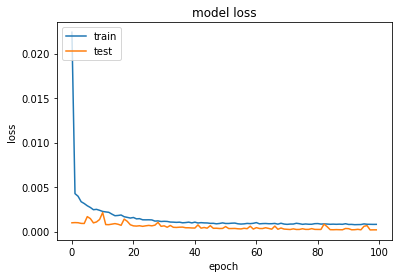

In [6]:
import matplotlib.pyplot as plt

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
# Part 3 - Making the predictions and visualising the results

# Getting the real KLCI price
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

y_test1 = y_test.reshape(len(y_test),1)
actual_stock_price = sc.inverse_transform(y_test1)

from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
print("Root Mean Square Error = " + str(rms))

Root Mean Square Error = 19.22541389880198


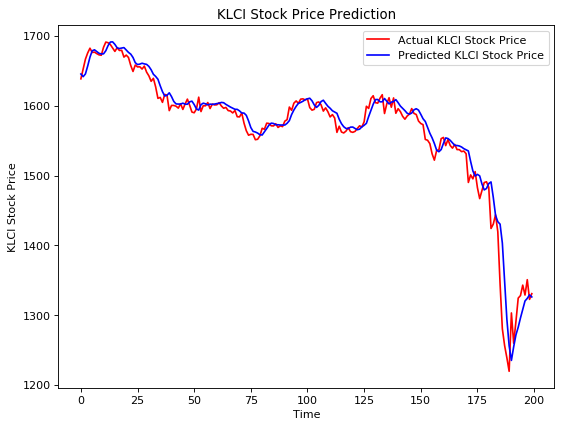

In [5]:
# Visualising the results
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(actual_stock_price, color = 'red', label = 'Actual KLCI Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted KLCI Stock Price')
plt.title('KLCI Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('KLCI Stock Price')
plt.legend()
plt.show()